[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NNDesignDeepLearning/NNDesignDeepLearning/blob/master/05.PythonChapter/Code/LabSolutions/PythonLab1_Solution.ipynb)

# Python Lab 1 Objective

This objective of this first Python lab is to help you become familiar with common Python operations that are often used in deep learning workflows. If you haven't already done so, run the cells in the `PythonChapter.ipynb` Jupyter Notebook to prepare for this lab.

Some of the cells in this notebook are prefilled with working code. In addition, there will be cells with missing code (labeled `# TODO`), which you will need to complete. If you need additional cells, you can use the `Insert` menu at the top of the page.

## Loading Modules

We begin by loading some useful modules.  In addition to NumPy and Pandas, we use the popular Python package, [Matplotlib](https://matplotlib.org/), to perform plotting. 

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Learning Rate Scheduler

When training neural networks with gradient descent, it is important to set the learning rate appropriately. If it is too small, the training will be slow. If is is too large, the training can become unstable. In addition, the best learning rate can change during the training. In the following cells we will define functions that can compute different learning rates at different epochs of training.

To begin, we define a simple algorithm that starts with a large learning rate and then reduces the rate during the training process by a certain factor at each epoch.

In [2]:
def lr_reduce(epoch):
    lr_decay = 0.8
    lr_max = 0.005
    lr_min = 0.001
    lr = (lr_max - lr_min)*lr_decay**epoch + lr_min
    return lr

To test this function, we calculate the learning rate up to an epoch of 20.

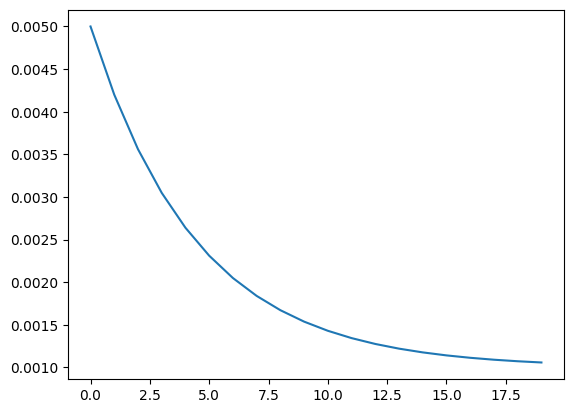

In [3]:
plt.plot(np.arange(20), [lr_reduce(ep) for ep in range(20)])

Using the idea of the `lr_reduce` function, create a function that starts at a low learning rate `lr_0`, increases linearly for `lr_0_steps` to a maximum of `lr_max`, holds at `lr_max` for `lr_max_steps` and then decays geometrically at a rate of `lr_decay` each epoch toward a minimum of `lr_min`.

In [4]:
def lr_increase_decrease(epoch):
    lr_0         = 0.001
    lr_0_steps   = 5
    lr_max       = 0.005
    lr_max_steps = 5
    lr_min       = 0.0005
    lr_decay     = 0.8

    if epoch < lr_0_steps:
        lr = lr_0 + (lr_max - lr_0)*epoch/lr_0_steps
    elif epoch < lr_0_steps + lr_max_steps:
        lr = lr_max
    else:
        lr = lr_min + (lr_max - lr_min)*lr_decay**(epoch - lr_0_steps - lr_max_steps)
        
    return lr

Test your function.

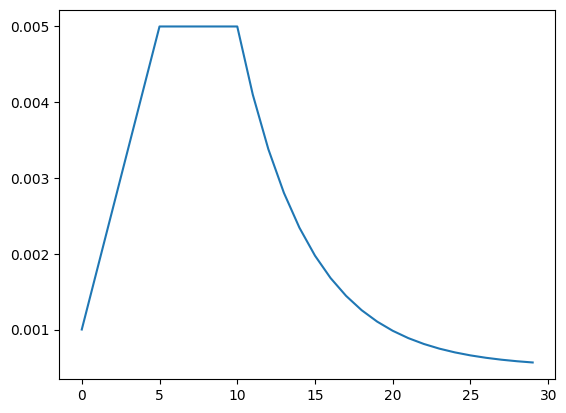

In [5]:
plt.plot(np.arange(30), [lr_increase_decrease(ep) for ep in range(30)])

Sometimes it is useful to create learning rate functions with different sets of parameters and to pass these functions to a training function. Using the ideas above, create a `Class` of *increase-then-reduce* learning rate functions. It should have `__init__` and `__call__` methods. The input to the `__call__` method should be epoch number, and the returned value should be the learning rate for that epoch.

In [6]:
class lr_inc_dec:
    def __init__(self, lr_0=0.001, lr_0_steps=5, lr_max = 0.005, lr_max_steps = 5, lr_min=0.0005, lr_decay=0.9):
        self.lr_0         = lr_0
        self.lr_max       = lr_max
        self.lr_0_steps   = lr_0_steps
        self.lr_max_steps = lr_max_steps
        self.lr_min       = lr_min
        self.lr_decay     = lr_decay
        
    def __call__(self, epoch):
        if epoch < self.lr_0_steps:
            self.lr = self.lr_0 + (self.lr_max - self.lr_0)*epoch/self.lr_0_steps
        elif epoch < self.lr_0_steps + self.lr_max_steps:
            self.lr = self.lr_max
        else:
            self.lr = self.lr_min + (self.lr_max - self.lr_min)*self.lr_decay**(epoch - self.lr_0_steps - self.lr_max_steps)
 
        return self.lr

Test your function

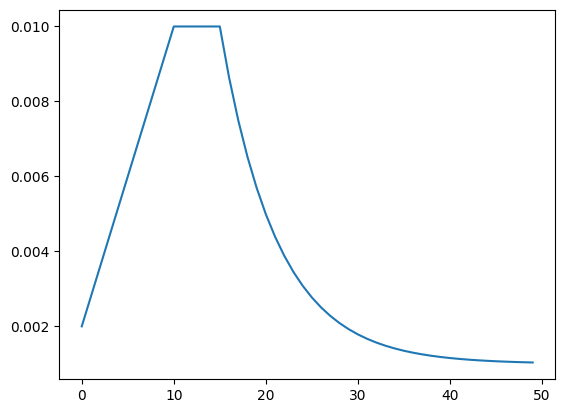

In [7]:
lr_scheduler = lr_inc_dec(lr_0=0.002, lr_0_steps=10, lr_max = 0.01, lr_max_steps = 5, lr_min=0.001, lr_decay=0.85)
plt.plot(np.arange(50), [lr_scheduler(ep) for ep in range(50)])

# Training a Simple Network

Consider the network and training data from Exercise E3.1. You are going to write some code to create the network and the training data, and then to train the network using steepest descent.

## Training Data

First, create NumPy arrays to hold the inputs and targets.

In [8]:
P = np.array([-1, 0, 1])
T = np.array([-1.5, 0.5, 2.5])
print(P)
print(T)

[-1  0  1]
[-1.5  0.5  2.5]


## Define the Network

The next step is to define the network. Define a network class, `simplenet`, to implement the network from Exercise E2.1. The `simplenet` object should have two attributes: the weight `.w` and the bias `.b`, which should be initialized in the `__init__` method. It should have a method called `sim`, which should return the network output for a given input (and should work for a single input, or a batch of inputs). It should also have a method `deriv`, which should return the derivative of the network output with respect to the weight and bias. The derivative will have two rows (the first for w and the second for b), and as many columns as the batch size.

In [9]:
class simplenet:
    def __init__(self, weight, bias):
        self.w = weight
        self.b = bias
        
    def sim(self, p):
        return self.w*p + self.b
    
    def deriv(self, p):
        return np.vstack((p, np.ones(p.shape[0])))

Test the network using an initial weight of 1 and a bias of 0. Use the training data as input. The network output should be [-1,  0,  1]. The derivative should be [[-1.,  0.,  1.], [ 1.,  1.,  1.]].

In [10]:
net = simplenet(1, 0)
A = net.sim(P)
print(A)
dA_dwb = net.deriv(P)
print(dA_dwb)

[-1  0  1]
[[-1.  0.  1.]
 [ 1.  1.  1.]]


## Performance Function

Now we define the performance (or loss) function. Define a mean square error performance class. The class should have two methods: `value`, which returns the value of the MSE, and `deriv`, which returns the derivative of the MSE with respect to the network output. The input to both methods should be the network output and the target output. The function should work for single examples, or a batch of any size. 

In [11]:
class mse:
    def value(self, a, t):
       perf = np.sum((t - a)**2)/np.prod(a.shape)
       return perf
    
    def deriv(self, a, t):
        df_da = -2*(t - a)
        return df_da

Test the function using the training targets and the network output you computed above. The MSE value should be 0.9166666, and the derivative should be [-1.,  1.,  3.].

In [12]:
test_mse = mse()
performance = test_mse.value(A, T)
print(performance)
dF_dA = test_mse.deriv(A, T)
print(dF_dA)

0.9166666666666666
[ 1. -1. -3.]


## Training Function

Now define a training function. There should be five inputs to the training function: 1) a network, 2) a performance function, 3) a learning rate scheduler, 4) the maximum number of epochs to train, and 5) the data set. The data set should be provided as a dictionary with two keys: `Input` and `Target`. The values in the dictionary should be NumPy arrays containing the training inputs and training targets.  

To compute the gradient, use the `perf.deriv`  and `net.deriv` methods and then multiply their outputs together ($\partial F/\partial \mathbf{x}=\partial F/\partial a\times \partial a/\partial \mathbf{x}$). Get the learning rate at each epoch from the learning rate scheduler. This will be a batch traning function, which will use the entire data set for each weight update, so each iteration is one epoch. (See Chapter 3 of the text for a discussion of batch training.) You can access the weight and bias attributes of the network with `net.w` and `net.b`.

Compute the performance at each epoch and store it in a list (use the `append` method). The training function should return two things: 1) the final trained network, and 2) the list of performance values.

In [13]:
def train_gd(net, perf, lr_sched, max_epoch, data):
    pp = data['Input']
    tt = data['Target']
    ff = []
    for ep in range(max_epoch):
        aa = net.sim(pp)
        ff.append(perf.value(aa, tt))
        df_da = perf.deriv(aa, tt)
        da_dw = net.deriv(pp)
        ngrad = np.matmul(da_dw, df_da)
        lr = lr_sched(ep)
        net.w -= lr*ngrad[0]
        net.b -= lr*ngrad[1]
    return net, ff

Test the training function.

In [14]:
lr_scheduler = lr_inc_dec(lr_0=0.01, lr_0_steps=10, lr_max = 0.03, lr_max_steps = 5, lr_min=0.02, lr_decay=0.85)
DATA = {'Input': P, 'Target': T}
PERF = mse()
MAX_EPOCH = 30
NET = simplenet(0.1, 0.1)

In [15]:
NET2, FF = train_gd(NET, PERF, lr_scheduler, MAX_EPOCH, DATA)

Plot the progress of the performance function during training. The performance should decay toward 0. You could try changing the learning rate scheduler to see how it affects the convergence of the network.

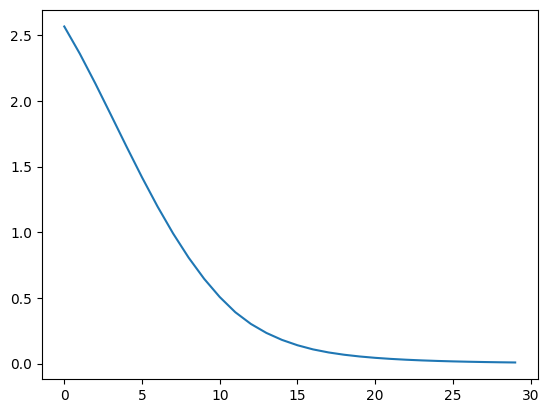

In [16]:
plt.plot(np.arange(MAX_EPOCH), FF)

# Using Pandas and a Data Generator

Now consider a little more complex problem, in which we load some data from a file into a Pandas DataFrame, transform the data, and then set up a data generator to read the data into mini-batches to train the network.

To begin, we read a CSV file into a DataFrame. This is the same file used in the Python Chapter Jupyter Notebook. For this task we will be trying to predict the **Percent** value from the **FVC** value.

In [17]:
#sample_df = pd.read_csv('https://raw.githubusercontent.com/NNDesignDeepLearning/NNDesignDeepLearning/master/05.PythonChapter/Code/ChapterNotebook/SampleDF.csv?token=AUZTTDQALCLLAYUY2ZZGDKDA5YTEK')

sample_df = pd.read_csv('../ChapterNotebook/SampleDF.csv')

In [18]:
print(sample_df.head())

                     Patient  Weeks   FVC    Percent  Age     Sex  \
0  ID00213637202257692916109     32  2972  81.828194   70    Male   
1  ID00129637202219868188000      0  2253  59.622102   71    Male   
2  ID00130637202220059448013     12  1648  68.116062   65  Female   
3  ID00225637202259339837603     23   969  49.075715   77  Female   
4  ID00082637202201836229724     33  2885  98.666211   49  Female   

      SmokingStatus  
0  Currently smokes  
1      Never smoked  
2      Never smoked  
3      Never smoked  
4  Currently smokes  


When training neural networks we commonly normalize the input and target data before training the network, as described in Chapter 4 of the textbook. For this problem let's normalize the inputs and targets to have a mean of 0 and a standard deviation of 1. In order to do that, compute the mean and standard deviation of the **FVC** and **Percent** columns in the DataFrame.

In [19]:
mean_fvc = sample_df['FVC'].mean()
std_fvc = sample_df['FVC'].std()
mean_percent = sample_df['Percent'].mean()
std_percent = sample_df['Percent'].std()

Now transform the **FVC** and **Percent** columns so that they have a mean of 0 and a standard deviation of 1. Use the `apply` method and a `lambda` function that subtracts the mean and divides by the standard deviation.

In [20]:
sample_df['FVC'] = sample_df['FVC'].apply(lambda x:(x-mean_fvc)/std_fvc)
sample_df['Percent'] = sample_df['Percent'].apply(lambda x:(x-mean_percent)/std_percent)

Assign the input variable `P` to the **FVC** column of the DataFrame and the target variable `T` to the **Percent** column of the DataFrame, after converting them to NumPy arrays.

In [21]:
P = np.array(sample_df['FVC'])
T = np.array(sample_df['Percent'])

As earlier, put the inputs and targets into a dictionary.

In [22]:
Data = {'Input': P, 'Target': T}

## Data Generator

We covered generators in the Python Chapter Jupyter Notebook. Let's make a generator that will be passed into the training function, which will use it to return mini-batches of the training data. The generator should continue to pass through the data set an indefinite number of times. It will shuffle the data set after each epoch. If the length of the data set is not an integer multiple of the batch size, some remainder of data points will be left out of each epoch, but because of shuffling, all data will eventually be included in training.

There will be two inputs to the generator: 1) the dictionary containing the data set and 2) the mini-batch size `bsize`. The generator should then extract the input and target from the dictionary and iterate through the data, extracting `bsize` columns from the input and target arrays at each iteration. 

On each iteration, the data generator should yield three things: 1) the epoch number, 2) `bsize` columns of the input array and 3) `bsize` columns of the target array. At the completion of each epoch, it should randomly reorder the columns of the input and target arrays, so that they will be presented in a different order on each epoch. (Hint: The function `np.random.permutation` can be useful in reordering the arrays. Be sure to use the same indexing for both inputs and targets.) The generator should be written so that it can be used for an arbitrary number of epochs. The training function will know when to stop accessing the generator when the epoch number reaches the desired number of epochs.

In [23]:
def data_gen(data, bsize):
    In = data['Input']
    Tar = data['Target']
    num = len(In)
    steps = num//bsize
    epoch = 0
    while True:
        for ii in range(steps):
            yield epoch, In[ii*bsize:(ii+1)*bsize], Tar[ii*bsize:(ii+1)*bsize]
        ind = np.random.permutation(num)
        In = In[ind]
        Tar = Tar[ind]
        epoch += 1

## Modified Training Function

Modify the earlier training function, `train_gd`, so that it's fifth input is a data generator, rather than the data set itself. It should still run for `max_epoch` epochs, but there will be multiple iterations for each epoch if the mini-batch size is smaller than the full data set size. 

The form of the `train_gd_gen` function will be almost identical to the `train_gd` function. However, instead of incrementing the epoch number, it will call the data generator with the `next` command, which will return the current epoch number. This epoch number will be used to access the correct learning rate.

Except for the data generator, the inputs and outputs of `train_gd_gen` will be the same as those of `train_gd`. However, the returned list of performance values will be provided at each iteration, which could be multiple times per epoch, depending on the mini-batch size.

In [24]:
def train_gd_gen(net, perf, lr_sched, max_epoch, datagen):
    ff = []
    ep = 0
    while ep  < max_epoch:
        ep, pp, tt = next(datagen)
        aa = net.sim(pp)
        ff.append(perf.value(aa, tt))
        df_da = perf.deriv(aa, tt)
        da_dw = net.deriv(pp)
        ngrad = np.matmul(da_dw, df_da)
        lr = lr_sched(ep)
        net.w -= lr*ngrad[0]
        net.b -= lr*ngrad[1]
    return net, ff

Now test the data generator and the new training function. In the values set below the mini-batch size is set to 10, which means that there will be 10 iterations per epoch, since there are 100 data points in the training set.

In [25]:
lr_scheduler = lr_inc_dec(lr_0=0.001, lr_0_steps=10, lr_max = 0.01, lr_max_steps = 10, lr_min=0.000001, lr_decay=0.85)
DATA = {'Input': P, 'Target': T}
BSIZE = 10
PERF = mse()
MAX_EPOCH = 50
NET = simplenet(0.1, 0.1)
gendata = data_gen(DATA, BSIZE)

In [26]:
NET2, FF = train_gd_gen(NET, PERF, lr_scheduler, MAX_EPOCH, gendata)

Let's plot the performance during training. You will notice that the plot is not as smooth as the earlier training example, which used full batch training. Since at each iteration the performance is computed over only a subset of the data, the convergence can be noisy. You can experiment with larger mini-batch sizes to see how this effects the convergence.

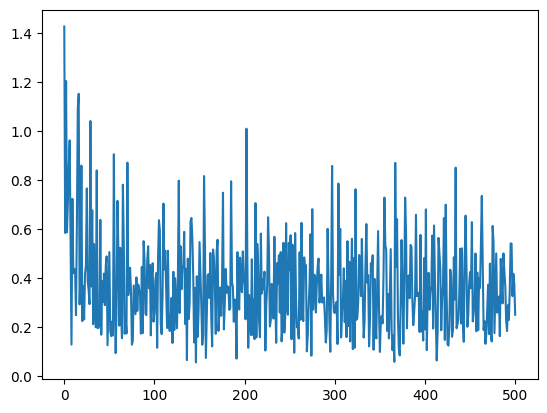

In [27]:
plt.plot(FF)

Finally, let's see how well the final trained network fit the training data. Here we find the network response to inputs over the range -3 to 3 (which is the approximate range of the normalized **FVC** values) and compare it to the training data. Since we only use a one layer network, the response of the network is linear. 

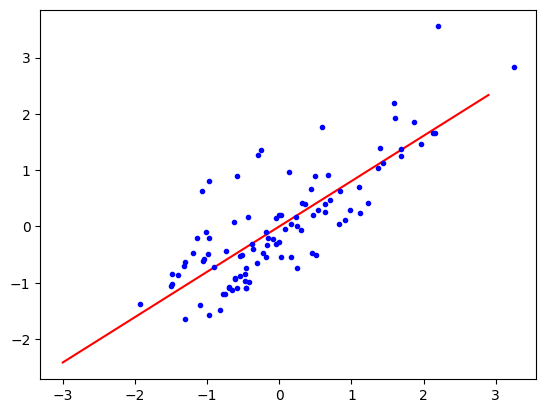

In [28]:
pp = np.arange(-3,3,0.1)
aa = NET2.sim(pp)
plt.plot(pp, aa, 'r', P, T, 'b.')

## Explore Further

Experiment with different learning rate schedules and mini-batch sizes to see how they affect training. 

Implement other training algorithms, such as Adam. 

Implement a two-layer network. 

Load your own data set.